In [2]:
import pandas as pd
import numpy as np
import glob
from enum import Enum
from datetime import datetime, date, timedelta

class Symnbol(Enum):
    SPX = 'SPX'
    SPY = 'SPY'
    XSP = 'XSP'
    QQQ = 'QQQ'
    RUT = 'RUT'
    NDX = 'NDX'
    AAPL = 'AAPL'
    TSLA = 'TSLA'

class TradeType(Enum):
    Butterfly = 'Butterfly'
    IronCondor = 'Iron Condor'
    Vertical = 'Vertical'
    Sonar = 'Sonar'

trade_legs = {
    TradeType.Butterfly: [1, -2, 1],
    TradeType.IronCondor: [-1, 1, -1, 1],
    TradeType.Vertical: [1, -1],
    TradeType.Sonar: [-1, 1, -1, 1],
}

# Map symbols to integer IDs
symbol_to_id = {symbol.value: idx for idx, symbol in enumerate(Symnbol)}
# Reverse mapping from IDs to symbols
id_to_symbol = {idx: symbol.value for idx, symbol in enumerate(Symnbol)}

# Map trade types to integer IDs
trade_type_to_id = {trade_type.value: idx for idx, trade_type in enumerate(TradeType)}
# Reverse mapping from IDs to trade types
id_to_trade_type = {idx: trade_type.value for idx, trade_type in enumerate(TradeType)}

# load data/raw/magic/*.csv files into a single pandas DataFrame

profits_files = glob.glob('data/results/magic/profits/*.csv')
df_profits = {file.split('/')[-1].split(' ')[1].split('-')[0]: pd.read_csv(file) for file in profits_files}

trades_files = glob.glob('data/results/magic/trades/*.csv')
df_trades = {file.split('/')[-1].split(' ')[1].split('-')[0]: pd.read_csv(file) for file in trades_files}

df_days = []

# Loop through both dictionaries based on matching keys
for key in df_profits.keys() & df_trades.keys():
    dfp = df_profits[key]
    dft = df_trades[key]

    # Remove rows where 'Name' is NaN
    dfp = dfp[dfp['Name'].notna()].copy()

    dfp['DateTime'] = pd.to_datetime(dfp['Day'], format='%m-%d-%Y') + pd.to_timedelta(dfp['Hour'] + ':00')
    dft['DateTime'] = pd.to_datetime(dft['Date'], format='mixed') + pd.to_timedelta(dft['Time'] + ':00')

    mindt_t = dft['DateTime'].min()
    mindt_p = dfp['DateTime'].min()
    delta = mindt_p.hour - mindt_t.hour

    dft['DateTime'] = dft['DateTime'] + timedelta(hours=delta)

    dfp.drop(columns=['Day', 'Hour', 'Predicted', 'Low', 'High', 'Closed', 'Stop', 'Managed', 'Premium', 'Risk', 'Reward'], inplace=True)
    dft.drop(columns=['Date', 'Time', 'Source', 'ExpectedMove', 'Low', 'High', 'Target1', 'Target2', 'Predicted', 'Trade'], inplace=True)
    
    # Merge dfp and dft on DateTime, Symbol, Name
    df = pd.merge(dft, dfp, on=['DateTime', 'Symbol', 'Name'], how='inner', suffixes=('_trade', '_profit'))

    # Sort by Date and preserve original order for same dates
    df = df.sort_values(by=['DateTime']).reset_index(drop=True)

    # Identify blocks of consecutive rows. A block is defined as a group of consecutive rows with different Symbol and/or Name values.
    # A new block starts when a Symbol, Name pair have already been seen in the current block.
    # Assign a number to each block in a new column 'Block'.
    df['Block'] = 0
    seen_pairs = set()
    block_number = 0
    for idx, row in df.iterrows():
        pair = (row['Symbol'], row['Name'])
        if pair in seen_pairs:
            block_number += 1
            seen_pairs = set()
        df.at[idx, 'Block'] = block_number
        seen_pairs.add(pair)
    
    # Set the DateTime column to be the maximum value for each block
    df['DateTime'] = df.groupby('Block')['DateTime'].transform('max')

    # Round date time down to the nearest 5-minute interval
    df['DateTime'] = df['DateTime'].dt.floor('5min')

    # Group by DateTime and find the minimum Block value for each DateTime
    min_blocks = df.groupby('DateTime')['Block'].min().reset_index()
    min_blocks.rename(columns={'Block': 'MinBlock'}, inplace=True)

    # Merge to get the MinBlock for each row
    df = df.merge(min_blocks, on='DateTime', how='left')

    # Keep only rows where Block equals MinBlock
    df = df[df['Block'] == df['MinBlock']]

    # Drop the temporary MinBlock column
    df.drop(columns=['MinBlock', 'Block'], inplace=True)
        
    df_days.append(df) 

df_data = pd.concat(df_days, ignore_index=True).sort_values(by=['DateTime']).reset_index(drop=True)

# Remove any Butterfly trades where Strike2 is not equidistant from Strike1 and Strike3
df_data = df_data[~((df_data['Name'] == 'Butterfly') &
                    ((df_data['Strike2'] - df_data['Strike1']) != (df_data['Strike3'] - df_data['Strike2'])))]


# Optional: Remove all butterfly trades
# df_data = df_data[df_data['Name'] != 'Butterfly'].copy()

# Remove 04-07-2025 trades
df_data = df_data[~((df_data['DateTime'].dt.date == date(2025, 4, 7)))]


# from FedTools import MonetaryPolicyCommittee
# fomc = MonetaryPolicyCommittee()
# fed_dates = fomc.find_statements()

# # Optional: Remove trades on FOMC dates (fed_dates.index)
# df_data = df_data[~df_data['DateTime'].dt.date.isin(fed_dates.index.date)]

# Remove where Strike1 .. Strike4 are not whole numbers, if they are not NaN
df_data = df_data[
    ~(((df_data['Strike1'] % 1 != 0) & df_data['Strike1'].notna()) |
      ((df_data['Strike2'] % 1 != 0) & df_data['Strike2'].notna()) |
      ((df_data['Strike3'] % 1 != 0) & df_data['Strike3'].notna()) |
      ((df_data['Strike4'] % 1 != 0) & df_data['Strike4'].notna()))
].copy()


# NEW: Remove trades where any required leg's Bid or Ask is zero based on trade Name
leg_count_map = {
    'Butterfly': 3,
    'Iron Condor': 4,
    'Vertical': 2,
    'Sonar': 4,
}

# Start with all rows kept; will set False for rows to remove
keep_mask = np.ones(len(df_data), dtype=bool)

# For each possible leg, if the trade type requires that leg then ensure both Bid and Ask are non-zero
for i in range(1, 5):
    leg_required = df_data['Name'].map(lambda nm: leg_count_map.get(nm, 4) >= i)
    bid_zero = df_data.get(f'Bid{i}') == 0
    ask_zero = df_data.get(f'Ask{i}') == 0
    # If leg is required and either bid or ask is zero -> mark for removal
    remove_i = leg_required & (bid_zero | ask_zero)
    keep_mask &= ~remove_i.values

df_data = df_data[keep_mask].copy()

# Indicates how far from the mid price we can buy/sell the options.
# At 0% slippage we buy/sell at the mid price.
# At 100% slippage we buy at the Ask price and sell at the Bid price.
SLIPPAGE_PERCENT = 0.0

df_data['Premium_orig'] = df_data['Premium'].copy()

# Recalculate the Premium column based on the Bid and Ask prices and the SLIPPAGE_PERCENT. Round to 2 decimal places towards the mid price.
# Define multipliers for each leg based on trade type, padded to 4 legs with 0 for missing legs
multipliers = {
    'Butterfly': [1, -2, 1, 0],
    'Iron Condor': [-1, 1, -1, 1],
    'Vertical': [-1, 1, 0, 0],
    'Sonar': [-1, 1, -1, 1]
}
df_data['Multiplier1'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[0])
df_data['Multiplier2'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[1])
df_data['Multiplier3'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[2])
df_data['Multiplier4'] = df_data['Name'].map(lambda x: multipliers.get(x, [0,0,0,0])[3])

# Compute mid prices
df_data['Mid1'] = (df_data['Bid1'] + df_data['Ask1']) / 2
df_data['Mid2'] = (df_data['Bid2'] + df_data['Ask2']) / 2
df_data['Mid3'] = (df_data['Bid3'] + df_data['Ask3']) / 2
df_data['Mid4'] = (df_data['Bid4'] + df_data['Ask4']) / 2

# Compute effective prices with slippage and round them — do both in one loop
for i in [1, 2, 3, 4]:
    eff_col = f'Effective{i}'
    mid_col = f'Mid{i}'
    bid_col = f'Bid{i}'
    ask_col = f'Ask{i}'
    mult_col = f'Multiplier{i}'

    # Compute effective price depending on the multiplier sign (buy at worse price for positive mult,
    # sell at worse price for negative mult; zero multiplier => 0)
    df_data[eff_col] = np.where(
        df_data[mult_col] > 0,
        df_data[mid_col] + SLIPPAGE_PERCENT * (df_data[ask_col] - df_data[mid_col]),
        np.where(
            df_data[mult_col] < 0,
            df_data[mid_col] - SLIPPAGE_PERCENT * (df_data[mid_col] - df_data[bid_col]),
            0.0,
        ),
    )

    # Round effective prices to 2 decimal places towards the mid price (preserve .005 tie-breaking)
    r = df_data[eff_col].round(2)
    mask_flat = (df_data[eff_col] - r).abs() == 0.005
    df_data[eff_col] = np.where(
        mask_flat & (r > df_data[mid_col]), r - 0.01,
        np.where(mask_flat & (r < df_data[mid_col]), r + 0.01, r)
    )

# Compute net premium
df_data['Premium'] = (
    df_data['Multiplier1'] * df_data['Effective1'] +
    df_data['Multiplier2'] * df_data['Effective2'] +
    df_data['Multiplier3'] * df_data['Effective3'] +
    df_data['Multiplier4'] * df_data['Effective4']
)

# Drop temporary columns
df_data.drop(columns=['Multiplier1', 'Multiplier2', 'Multiplier3', 'Multiplier4', 'Mid1', 'Mid2', 'Mid3', 'Mid4', 'Effective1', 'Effective2', 'Effective3', 'Effective4'], inplace=True)

df_data['Premium_calc'] = df_data['Premium'].copy()


# Recalculate Risk based on trade type:
# Butterfly: Risk = Premium * 100 (debit position)
# Iron Condor, Sonar: Risk = (Width of wider spread + Premium) * 100 (credit position, premium is negative)
# Vertical: Risk = Width of the spread * 100 + Premium (credit position, premium is negative)
def calculate_risk(row):
    if row['Name'] == 'Butterfly':
        return row['Premium'] * 100
    elif row['Name'] == 'Iron Condor' or row['Name'] == 'Sonar':
        width1 = abs(row['Strike2'] - row['Strike1'])
        width2 = abs(row['Strike4'] - row['Strike3'])
        wider_width = max(width1, width2)
        return (wider_width + row['Premium']) * 100
    elif row['Name'] == 'Vertical':
        width = abs(row['Strike2'] - row['Strike1'])
        return (width + row['Premium']) * 100
    else:
        return row['Risk']  # Fallback to original Risk if trade type is unknown

df_data['Risk_orig'] = df_data['Risk'].copy()
df_data['Risk'] = df_data.apply(calculate_risk, axis=1)

# Remove rows where Risk is negative or zero
df_data = df_data[df_data['Risk'] > 0].copy()

# Calculate a Profit column. The original profit is in the "Raw" column. Need to adjust based on the difference in Risk_orig and Risk
# Profit = Raw + Risk_orig - Risk
df_data['Profit'] = df_data['Raw'] + df_data['Risk_orig'] - df_data['Risk']

settlement_type = {
    'SPX': 'Cash',
    'SPY': 'Physical',
    'XSP': 'Cash',
    'QQQ': 'Physical',
    'RUT': 'Cash',
    'NDX': 'Cash',
    'AAPL': 'Physical',
    'TSLA': 'Physical',
}

COMMISSION_PER_CONTRACT = 1.15  # $0.85 per contract

# Calculate commissions based on trade type and number of contracts (assume 1 contract per leg) and settlement type.
# For cash we only pay the commission once, for physical we pay it twice (opening and closing)
def calculate_commission(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    base_commission = num_legs * COMMISSION_PER_CONTRACT

    # Cash-settled: pay only opening commission
    if settlement_type.get(row['Symbol'], 'Physical') == 'Cash':
        return base_commission  # Pay once for cash settled

    # Physical-settled: pay opening commission for all legs, plus closing commission
    # only for legs that are in-the-money at EOD.
    closing_price = row.get('Closing')  # underlying closing price at EOD
    if pd.isna(closing_price):
        # If no closing price available, conservatively assume no closing commissions
        closing_commission = 0.0
    else:
        closing_commission = 0.0
        # Only consider the legs that the trade uses (1..num_legs)
        for i in range(1, num_legs + 1):
            strike_col = f'Strike{i}'
            type_col = f'Type{i}'
            strike = row.get(strike_col)
            typ = row.get(type_col)

            # skip missing data
            if pd.isna(strike) or pd.isna(typ):
                continue

            typ_upper = str(typ).upper()
            # CALL is ITM if closing_price > strike
            if typ_upper.startswith('C'):
                if closing_price > strike:
                    closing_commission += COMMISSION_PER_CONTRACT
            # PUT is ITM if closing_price < strike
            elif typ_upper.startswith('P'):
                if closing_price < strike:
                    closing_commission += COMMISSION_PER_CONTRACT
            else:
                # Unknown type: skip
                continue

    # total = opening commissions + closing commissions only for ITM legs
    return base_commission + closing_commission
    
df_data['Commission'] = df_data.apply(calculate_commission, axis=1)
df_data['NetProfit'] = df_data['Profit'] - df_data['Commission']

import pandas as pd
import numpy as np

# Assuming leg_count_map and settlement_type are defined elsewhere as in the original code

COMMISSION_PER_CONTRACT = 0.85  # $0.85 per contract

def calculate_max_itm(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    legs = []
    for i in range(1, num_legs + 1):
        strike_col = f'Strike{i}'
        type_col = f'Type{i}'
        strike = row.get(strike_col)
        typ = row.get(type_col)
        if pd.isna(strike) or pd.isna(typ):
            continue
        legs.append((strike, typ))
    
    if not legs:
        return 0.0
    
    strikes = [leg[0] for leg in legs if not pd.isna(leg[0])]
    if not strikes:
        return 0.0
    
    unique_strikes = sorted(set(strikes))
    min_s = min(unique_strikes)
    max_s = max(unique_strikes)
    test_points = [min_s - 1]
    for j in range(len(unique_strikes) - 1):
        mid = (unique_strikes[j] + unique_strikes[j + 1]) / 2
        test_points.append(mid)
    test_points.append(max_s + 1)
    
    max_count = 0
    for s in test_points:
        count = 0
        for strike, typ in legs:
            typ_upper = str(typ).upper()
            if typ_upper.startswith('C'):
                if s > strike:
                    count += 1
            elif typ_upper.startswith('P'):
                if s < strike:
                    count += 1
        max_count = max(max_count, count)
    
    return max_count

def calculate_max_commission(row):
    num_legs = leg_count_map.get(row['Name'], 4)
    base_commission = num_legs * COMMISSION_PER_CONTRACT
    sett = settlement_type.get(row['Symbol'], 'Physical')
    if sett == 'Cash':
        return base_commission
    else:
        max_itm = calculate_max_itm(row)
        closing_commission = max_itm * COMMISSION_PER_CONTRACT
        return base_commission + closing_commission

df_data['NetRisk'] = df_data['Risk'] + df_data.apply(calculate_max_commission, axis=1)

df_data['Weekday'] = df_data['DateTime'].dt.weekday  # Monday=0, Sunday=6


In [3]:
# Optional: Remove TSLA and AAPL trades
df_data = df_data[~df_data['Symbol'].isin(['TSLA', 'AAPL'])]

# Remove rows from the last hour of trading (>= 15:00)
df_data = df_data[df_data['DateTime'].dt.hour < 15]

df_processed = pd.DataFrame()

df_processed['DateInt'] = df_data['DateTime'].apply(lambda x: x.year * 10000 + x.month * 100 + x.day)
df_processed['TimeInt'] = df_data['DateTime'].apply(lambda x: x.hour * 100 + (x.minute // 5) * 5)
df_processed['SymbolID'] = df_data['Symbol'].map(symbol_to_id)
df_processed['TradeID'] = df_data['Name'].map(trade_type_to_id)
df_processed['Weekday'] = df_data['Weekday']

df_processed['ProfitPercent'] = np.where(df_data['NetRisk'] == 0, 0, df_data['NetProfit'] / (df_data['NetRisk']))


In [4]:
df_sorted = df_data.copy()
df_sorted['ProfitPercent'] = np.where(df_data['Risk'] == 0, 0, df_data['NetProfit'] / (df_data['NetRisk']))
# df_sorted = df_sorted.sort_values(by=['ProfitPercent'], ascending=False)
df_sorted = df_sorted[(df_sorted['Symbol'] == 'SPY') & (df_sorted['Name'] == 'Butterfly') & (df_sorted['DateTime'].dt.hour == 11) & (df_sorted['DateTime'].dt.minute == 10)]
df_sorted = df_sorted.sort_values(by=['ProfitPercent'], ascending=False)
df_sorted[['Symbol', 'Name', 'DateTime', 'Risk', 'NetRisk', 'Risk_orig', 'Raw', 'Profit', 'NetProfit', 'ProfitPercent', 'Closing', 'Trade']].head(20)



,Symbol,Name,DateTime,Risk,NetRisk,Risk_orig,Raw,Profit,NetProfit,ProfitPercent,Closing,Trade
210152,SPY,Butterfly,2025-03-07 11:10:00,80.0,85.1,80.0,228.0,228.0,222.25,2.611633,574.9200,BUY +1 Butterfly SPY 100 07 Mar 25 578/574/570...
261334,SPY,Butterfly,2025-04-14 11:10:00,132.0,137.1,131.0,292.0,291.0,286.40,2.088986,538.2290,BUY +1 Butterfly SPY 100 14 Apr 25 544/539/534...
172911,SPY,Butterfly,2025-02-07 11:10:00,126.0,131.1,127.0,265.0,266.0,261.40,1.993898,600.9200,BUY +1 Butterfly SPY 100 07 Feb 25 605/601/597...
284439,SPY,Butterfly,2025-05-01 11:10:00,114.0,119.1,114.0,182.0,182.0,177.40,1.489505,556.9600,BUY +1 Butterfly SPY 100 01 May 25 564/559/554...
470541,SPY,Butterfly,2025-09-17 11:10:00,171.0,176.1,171.0,263.0,263.0,257.25,1.460818,659.6600,BUY +1 Butterfly SPY 100 17 Sep 25 664/659/654...
143615,SPY,Butterfly,2025-01-16 11:10:00,138.0,143.1,140.0,195.0,197.0,192.40,1.344514,591.3500,BUY +1 Butterfly SPY 100 16 Jan 25 596/592/588...
292431,SPY,Butterfly,2025-05-07 11:10:00,180.0,185.1,179.0,255.0,254.0,248.25,1.341167,561.6600,BUY +1 Butterfly SPY 100 07 May 25 566/561/556...
266948,SPY,Butterfly,2025-04-17 11:10:00,156.0,161.1,157.0,203.0,204.0,198.25,1.230602,527.4000,BUY +1 Butterfly SPY 100 17 Apr 25 531/526/521...
224133,SPY,Butterfly,2025-03-18 11:10:00,204.0,209.1,205.0,262.0,263.0,257.25,1.230273,561.3300,BUY +1 Butterfly SPY 100 18 Mar 25 566/561/556...
216122,SPY,Butterfly,2025-03-12 11:10:00,148.0,153.1,149.0,191.0,192.0,186.25,1.216525,558.6000,BUY +1 Butterfly SPY 100 12 Mar 25 562/557/552...


In [135]:
import torch

# Load the first 4 columns (indices) into an int tensor
indices_tensor = torch.tensor(df_processed.iloc[:, :4].values, dtype=torch.int32, device='cuda')

# Load ProfitPercent separately
profit_percent = torch.tensor(df_processed['ProfitPercent'].values, dtype=torch.float32, device='cuda')

# Get unique sorted values for each of the first 4 columns
unique_dates = torch.unique(indices_tensor[:, 0]).sort().values
unique_times = torch.unique(indices_tensor[:, 1]).sort().values
unique_symbols = torch.unique(indices_tensor[:, 2]).sort().values
unique_trades = torch.unique(indices_tensor[:, 3]).sort().values

# Get the df_processed['Weekday'] values for each unique date
date_to_weekday = {date: weekday for date, weekday in zip(df_processed['DateInt'], df_processed['Weekday'])}
unique_weekdays = torch.tensor([date_to_weekday[date.item()] for date in unique_dates], dtype=torch.int32, device='cuda')

# Initialize 4D tensor with shape based on unique counts
profits = torch.zeros((len(unique_dates), len(unique_times), len(unique_symbols), len(unique_trades)), dtype=torch.float32, device='cuda')

# Populate the tensor with ProfitPercent values using vectorized indexing
date_indices = torch.bucketize(indices_tensor[:, 0], unique_dates)
time_indices = torch.bucketize(indices_tensor[:, 1], unique_times)
symbol_indices = torch.bucketize(indices_tensor[:, 2], unique_symbols)
trade_indices = torch.bucketize(indices_tensor[:, 3], unique_trades)

profits[date_indices, time_indices, symbol_indices, trade_indices] = profit_percent
win_rate = (profits > 0).float().mean(dim=0)
profits_backup = profits.clone()


In [6]:
import torch

# --- Frank–Wolfe with exact 1-D line search on {x>=0, sum<=1} ------------------
@torch.compile()
def maximise_f_frank_wolfe_leq1_v2(
    A: torch.Tensor,
    *,
    max_iter: int = 100_000,
    tol_gap: float | None = None,
    rel_gap: float = 1e-8,
    tol_df: float | None = None,
    patience: int = 20,
    eps: float = 1e-12,
    max_ls_it: int = 40,
):
    """
    Maximise f(x)=sum_i log(1 + (A x)_i) over {x>=0, sum(x)<=1} by Frank–Wolfe.
    """
    finfo = torch.finfo(A.dtype)
    if tol_gap is None: tol_gap = 100 * finfo.eps
    if tol_df  is None: tol_df  = 10 * finfo.eps

    _, n = A.shape

    x = torch.zeros(n, device=A.device, dtype=A.dtype)

    def fval(x):
        return torch.log1p(torch.clamp(A @ x, min=-1 + eps)).sum()

    f_prev = fval(x)
    stall = 0
    steps = 0
    gap = torch.tensor(float('inf'), device=A.device, dtype=A.dtype)

    for _ in range(max_iter):
        s = A @ x                         # (m,)
        w = 1.0 / torch.clamp(1.0 + s, min=eps)
        g = A.t().matmul(w)               # (n,) gradient wrt x

        # pick vertex v = argmax_{v in {0, e_j}} <g, v>  (0 is new)
        k = int(torch.argmax(g))
        if g[k] <= 0:
            v = torch.zeros_like(x)       # CHANGED: choose the zero-vertex if all g_j <= 0
        else:
            v = torch.zeros_like(x); v[k] = 1.0

        # FW gap for maximisation: gap = <g, v - x>  (>=0 by construction)
        gap = (g.dot(v) - g.dot(x))

        # stop on absolute/relative gap
        f_now = f_prev
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_now))):
            break

        # Line search on phi(gamma) = sum_i log(1 + s_i + gamma * t_i)
        t_vec = A @ (v - x)

        def dphi(gamma: float):
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            return torch.sum(t_vec / denom)

        d0 = dphi(0.0)                    # equals gap
        d1 = dphi(1.0)

        if d1 > 0.0:
            gamma = 1.0                   # jump fully to the chosen vertex
        elif d0 <= 0.0:
            gamma = 0.0                   # already optimal along this direction
        else:
            lo, hi = 0.0, 1.0             # bisection to solve dphi(gamma)=0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)

        # Feasible convex update keeps sum<=1 automatically
        x = (1.0 - gamma) * x + gamma * v

        # Stall guard on |Δf|
        f_new = fval(x)
        if abs(f_new - f_prev) <= tol_df:
            stall += 1
            if stall >= patience:
                break
        else:
            stall = 0
        f_prev = f_new
        steps += 1
   
    print(f"steps={steps}, gap={gap.item():.3e}, fval={f_prev.item():.6e}")
   
    return x, f_prev.item()


In [7]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Dict, Any

@torch.no_grad()
def fw_solve_l1ball_static_ratio(
    A: torch.Tensor,                       # (m, n)
    *,
    removed: Optional[torch.Tensor] = None,# (n,) bool mask of "deleted" cols
    x0: Optional[torch.Tensor] = None,     # feasible warm start
    max_iter: int = 100_000,
    tol_gap: Optional[float] = None,
    rel_gap: float = 1e-8,
    eps: float = 1e-12,                    # guard for log domain: 1+s >= eps
    sigma_eps: float = 1e-12,              # guard for std: sqrt(var + sigma_eps)
    max_ls_it: int = 40,
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Nonconvex Frank–Wolfe for F(x)=sum(log1p(Ax)) / (std(Ax)+1), over {x>=0, sum(x)<=1}.
    Static shapes, no in-place. Use multiple restarts for better solutions.
    """
    device, dtype = A.device, A.dtype
    m, n = A.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None:
        tol_gap = 100 * finfo.eps
    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    removed = removed if removed is not None else torch.zeros(n, device=device, dtype=torch.bool)
    keep = (~removed).to(dtype)

    # Safe init (avoid (-inf)*0): use zeroed A for s and for gradient products
    A_zero_removed = torch.where(removed.unsqueeze(0), torch.zeros_like(A), A)

    # ---- init x, s = A x ----
    if x0 is None:
        x = torch.zeros(n, device=device, dtype=dtype)
        s = torch.zeros(m, device=device, dtype=dtype)
    else:
        x = torch.clamp(x0.to(device=device, dtype=dtype), min=0)
        x = x * keep
        sx = x.sum()
        x = torch.where(sx > 1 + 1e-12, x / sx, x)
        s = A_zero_removed.matmul(x)

    # helpers
    def f_N_D(s_vec: torch.Tensor):
        # Numerator, denominator, std pieces
        s_clamped = torch.clamp(s_vec, min=-1 + eps)
        N = torch.log1p(s_clamped).sum()
        c = s_vec - s_vec.mean()
        var = c.square().mean()
        sigma = torch.sqrt(var + sigma_eps)
        D = sigma + 1.0
        return N, D, c, sigma

    def f_value(s_vec: torch.Tensor) -> float:
        N, D, _, _ = f_N_D(s_vec)
        return (N / D).item()

    # current value
    f_val = f_value(s)
    gap = float("inf")
    it = 0

    for it in range(max_iter):
        # grad wrt s
        N, D, c, sigma = f_N_D(s)
        grad_N = 1.0 / torch.clamp(1.0 + s, min=eps)          # (m,)
        grad_sigma = c / (m * sigma)                           # (m,)
        grad_s = grad_N / D - (N / (D * D)) * grad_sigma       # (m,)

        # g = A^T grad_s using ZEROED columns to avoid (-inf)*0
        g = A_zero_removed.t().matmul(grad_s)                  # (n,)
        # forbid removed cols in LMO
        g = torch.where(removed, neg_inf, g)

        # LMO over {0, e1,...,en}
        g_max_val, k = torch.max(g, dim=0)
        v_is_zero = g_max_val.item() <= 0.0

        # Nonconvex FW gap (stationarity measure)
        g_for_dot = torch.where(x > 0, g, torch.zeros_like(g)) # avoid (-inf)*0
        gap = max(g_max_val.item(), 0.0) - (g_for_dot * x).sum().item()
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_val))):
            break

        # Direction t = A@(v - x) (no explicit v)
        t_vec = (-s) if v_is_zero else (A[:, k] - s)

        # 1-D line search on gamma ∈ [0,1]
        def N_D_at(gamma: float):
            sg = s + gamma * t_vec
            return f_N_D(sg)

        def dphi(gamma: float) -> float:
            # derivative along t: (N' D - N D')/D^2
            Ng, Dg, cg, sigmag = N_D_at(gamma)
            # N' = sum t_i / (1 + s_i + gamma t_i)
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            Nprime = torch.sum(t_vec / denom)
            # D' = <c(gamma), t> / (m * sigma(gamma))
            Dprime = torch.dot(cg, t_vec) / (m * sigmag)
            return ((Nprime * Dg - Ng * Dprime) / (Dg * Dg)).item()

        def phi(gamma: float) -> float:
            return f_value(s + gamma * t_vec)

        d0, d1 = dphi(0.0), dphi(1.0)
        if d1 > 0.0:
            gamma = 1.0
        elif d0 < 0.0:
            gamma = 0.0
        elif d0 > 0.0 and d1 < 0.0:
            # bisection on derivative root
            lo, hi = 0.0, 1.0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)
        else:
            # fallback: pick best among a tiny grid (robust for non-concave case)
            cand = torch.tensor([0.0, 0.5, 1.0], device=device, dtype=dtype)
            vals = torch.tensor([phi(float(c)) for c in cand], device=device, dtype=dtype)
            gamma = float(cand[torch.argmax(vals)])

        # functional updates (no in-place)
        if v_is_zero:
            x = (1.0 - gamma) * x
        else:
            one_hot = F.one_hot(k, num_classes=n).to(dtype=dtype, device=device)
            x = (1.0 - gamma) * x + gamma * one_hot

        s = s + gamma * t_vec
        f_val = f_value(s)

    info = {"iters": it + 1, "gap": gap, "sumx": x.sum().item()}
    return x, f_val, info


In [8]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Dict, Any

# ----------------------- 1) FW solver (static-shape, no in-place) -----------------------

@torch.no_grad()
def fw_solve_l1ball_static(
    A_masked: torch.Tensor,                 # A with removed columns set to -inf (same shape as A)
    *,
    removed: Optional[torch.Tensor] = None, # (n,) bool mask of removed columns
    x0: Optional[torch.Tensor] = None,      # (n,) warm start (feasible: x>=0, sum<=1)
    max_iter: int = 100_000,
    tol_gap: Optional[float] = None,        # absolute dual-gap tol
    rel_gap: float = 1e-8,                  # relative dual-gap tol
    eps: float = 1e-12,                     # guard for log domain
    max_ls_it: int = 40,                    # bisection steps
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Maximise f(x)=Σ log(1 + (A x)_i) over {x>=0, Σx<=1} via Frank–Wolfe
    using fixed shapes (no slicing) and no in-place ops.
    `A_masked` must have -inf in removed columns; others unchanged.
    """

    device, dtype = A_masked.device, A_masked.dtype
    m, n = A_masked.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None:
        tol_gap = 100 * finfo.eps

    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    def f_from_s(s: torch.Tensor) -> torch.Tensor:
        return torch.log1p(torch.clamp(s, min=-1 + eps)).sum()

    # ---------- initialise x & s (careful to avoid (-inf)*0) ----------
    if x0 is None:
        x = torch.zeros(n, device=device, dtype=dtype)
        s = torch.zeros(m, device=device, dtype=dtype)
    else:
        x = torch.clamp(x0.to(device=device, dtype=dtype), min=0.0)
        # zero out removed coords in x (functional)
        if removed is not None:
            x = x * (~removed).to(dtype)
        sx = x.sum()
        x = torch.where(sx > 1 + 1e-12, x / sx, x)

        # To compute s=A@x without NaNs, zero removed columns just for this product
        if removed is None:
            A_for_s = A_masked  # no -inf present => safe
        else:
            A_for_s = torch.where(removed.unsqueeze(0), torch.zeros_like(A_masked), A_masked)
        s = A_for_s.matmul(x)

    f_val = f_from_s(s).item()
    gap = float("inf")
    it = 0

    for it in range(max_iter):
        # grad g = A^T * (1 / (1 + s))
        w = 1.0 / torch.clamp(1.0 + s, min=eps)
        g = A_masked.t().matmul(w)  # (n,)

        # Exclude removed columns from LMO by forcing g=-inf there
        if removed is not None and removed.any():
            g = torch.where(removed, neg_inf, g)

        # LMO over {0, e1,...,en}
        g_max_val, k = torch.max(g, dim=0)
        v_is_zero = g_max_val.item() <= 0.0

        # Duality gap: max(0, max_j g_j) - <g, x>, but avoid (-inf)*0
        g_for_dot = torch.where(x > 0, g, torch.zeros_like(g))
        gap = max(g_max_val.item(), 0.0) - (g_for_dot * x).sum().item()
        if abs(gap) <= max(tol_gap, rel_gap * (1.0 + abs(f_val))):
            break

        # Direction t = A@(v-x) (without forming v explicitly)
        t_vec = (-s) if v_is_zero else (A_masked[:, k] - s)

        # Exact line search by bisection on derivative dφ(γ)
        def dphi(gamma: float) -> float:
            denom = torch.clamp(1.0 + s + gamma * t_vec, min=eps)
            return torch.sum(t_vec / denom).item()

        d0 = dphi(0.0)
        d1 = dphi(1.0)
        if d1 > 0.0:
            gamma = 1.0
        elif d0 <= 0.0:
            gamma = 0.0
        else:
            lo, hi = 0.0, 1.0
            for _ in range(max_ls_it):
                mid = 0.5 * (lo + hi)
                if dphi(mid) > 0.0:
                    lo = mid
                else:
                    hi = mid
            gamma = 0.5 * (lo + hi)

        # Update x (functional)
        if v_is_zero:
            x = (1.0 - gamma) * x
        else:
            one_hot = F.one_hot(k, num_classes=n).to(dtype=dtype, device=device)
            x = (1.0 - gamma) * x + gamma * one_hot

        # Update s via rank-1 update (no matmul, no in-place)
        s = s + gamma * t_vec
        f_val = f_from_s(s).item()

    info = {"iters": it + 1, "gap": gap, "sumx": x.sum().item()}
    return x, f_val, info


# ------------------- 2) Outer iterative prune (static-shape wrapper) --------------------

@torch.no_grad()
def fw_iterative_prune_static(
    A: torch.Tensor,                       # (m, n) original matrix
    *,
    tau: Optional[float] = None,           # prune if min positive mass < tau
    max_nnz: Optional[int] = None,         # enforce nnz <= max_nnz
    max_outer: Optional[int] = None,       # safety cap on pruning rounds
    # inner FW settings
    tol_gap: Optional[float] = None,
    rel_gap: float = 1e-6,
    inner_max_iter: int = 2000,
    eps: float = 1e-12,
) -> Tuple[torch.Tensor, float, Dict[str, Any]]:
    """
    Static-shape pruning wrapper:
      - Keeps shapes fixed (never slices A).
      - Virtually removes columns by setting them to -inf via a boolean mask.
      - Avoids in-place tensor edits.
    """
    device, dtype = A.device, A.dtype
    m, n = A.shape
    finfo = torch.finfo(dtype)
    if tol_gap is None: tol_gap = 100 * finfo.eps
    if max_outer is None:     max_outer = n

    neg_inf = torch.tensor(float("-inf"), device=device, dtype=dtype)

    removed = torch.zeros(n, device=device, dtype=torch.bool)
    x0 = torch.zeros(n, device=device, dtype=dtype)

    history: Dict[str, Any] = {"removed_idx": [], "round_info": []}
    rounds = 0
    x = x0.clone()
    f_fast = float('-inf')
    info_fast = {}

    while rounds < max_outer:
        rounds += 1

        # Build masked A (no in-place): removed columns -> -inf
        A_masked = torch.where(removed.unsqueeze(0), neg_inf, A)

        # Inner fast FW solve with warm start x0
        x, f_fast, info_fast = fw_solve_l1ball_static(
            A_masked,
            removed=removed,
            x0=x0,
            max_iter=inner_max_iter,
            tol_gap=tol_gap,
            rel_gap=rel_gap,
            eps=eps,
        )

        # Decide if we need to prune one coordinate
        pos_mask = x > 0
        nnz = int(pos_mask.sum().item())

        # Candidate index to remove (global index)
        remove_idx: Optional[int] = None

        # Enforce max_nnz first
        if max_nnz is not None and nnz > max_nnz:
            # pick smallest positive mass
            candidates = torch.where(
                pos_mask, x, torch.full_like(x, float('inf'))
            )
            remove_idx = int(torch.argmin(candidates).item())

        # Else prune by threshold if set
        if remove_idx is None and tau is not None and nnz > 0:
            # global min among positives
            candidates = torch.where(
                pos_mask, x, torch.full_like(x, float('inf'))
            )
            min_val, argmin_idx = torch.min(candidates, dim=0)
            if min_val.item() < tau:
                remove_idx = int(argmin_idx.item())

        # Nothing to prune: do a final tight FW pass and return
        if remove_idx is None:
            return x, f_fast, {
                "outer_rounds": rounds,
                "inner_history": history,
                "final_info": info_fast,
                "stopped_reason": "no_more_pruning",
            }

        # Update removed mask (functional, no in-place)
        remove_onehot = F.one_hot(
            torch.tensor(remove_idx, device=device), num_classes=n
        ).to(dtype=torch.bool)
        removed = torch.logical_or(removed, remove_onehot)

        # Warm start for next round: zero the removed coord(s), keep others
        x0 = x * (~removed).to(dtype)

        # Record history
        history["removed_idx"].append(remove_idx)
        history["round_info"].append(
            {"round": rounds, "removed": remove_idx, "nnz_before": nnz, **info_fast}
        )
        print(f"Round {rounds}: removed idx {remove_idx}, nnz before={nnz}, f_fast={f_fast:.6e}, gap={info_fast['gap']:.6e}")

    out_info = {
        "outer_rounds": rounds,
        "inner_history": history,
        "final_info": info_fast,
        "stopped_reason": "max_outer_reached",
    }
    return x, f_fast, out_info


In [ ]:
from einops import rearrange, repeat

# Rearrange the tensor so that time, symbol and trade dimensions are merged into a batch dimension, and date dimension is the sequence dimension
# profits_thursday = profits[unique_weekdays == 3, :, :, :]
profits = profits_backup.clone()

profits_flat = rearrange(profits, 'd t s tr -> d (t s tr)')
mask = torch.ones_like(profits)

# Keep only Thursday trades in the mask
# mask[unique_weekdays != 3, :, :, :] = 0.0

# mask = mask * (win_rate >= 0.80).unsqueeze(0).float()

# mask = mask * (profits.mean(dim=0) >= 0.0).unsqueeze(0).float()

# mask[-40:, :, :, :] = 0.0

sharpe = (profits.mean(dim=0)) / profits.std(dim=0)
# mask = mask * (sharpe >= 1.5).unsqueeze(0).float()
#sharpe = profits[:-40, :, :, :].mean(dim=0) / profits[:-40, :, :, :].std(dim=0)
# log_profits = torch.log1p(profits * 0.25)
# lp_mean = log_profits.mean(dim=0)
# sharpe = torch.where(lp_mean > 0, lp_mean / log_profits.std(dim=0), lp_mean)
print(f"Sharpe: mean={sharpe.mean().item():.3f}, max={sharpe.max().item():.3f}, min={sharpe.min().item():.3f}")
TOPK = 1
# Keep the top N sharpe trades
topk_vals, topk_idx = torch.topk(sharpe.flatten(), TOPK)
topk_mask = torch.zeros_like(sharpe.flatten())
topk_mask[topk_idx] = 1.0
topk_mask = topk_mask.view(sharpe.shape)
mask = mask * topk_mask.unsqueeze(0).float()


mask = mask * (sharpe >= 0.2).unsqueeze(0).float()

# Keep only trades which have improved in the last 120 days
# sharpe_120 = (profits[-120:, :, :, :].mean(dim=0) + 1.0) / profits[-120:, :, :, :].std(dim=0)
# mask = mask * (sharpe_120 > sharpe + 0.1).unsqueeze(0).float()


#days_n = mask[:,0,0,0].sum().item()
#days_n = profits_flat.shape[0]
mask_flat = rearrange(mask, 'd t s tr -> d (t s tr)')

days_n = mask_flat.max(dim=1).values.sum().item()
print(f"Using {days_n} days of data; Total trades = {mask_flat.sum().item()}, Avg per day = {mask_flat.sum().item()/days_n:.1f}")

# Risk modifier: Multiply negative profits by a risk factor > 1.0 to penalize them more heavily
risk_factor = torch.tensor(1.0, device=profits_flat.device, dtype=profits_flat.dtype)
risk_mod = torch.where(profits_flat < 0.0, risk_factor, 1.0)


Sharpe: mean=-0.003, max=0.668, min=-0.336
Using 120.0 days of data; Total trades = 600.0, Avg per day = 5.0


In [253]:
# kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat * mask_flat * risk_mod, max_iter=100000, tol_gap=1.0e-3, tol_df=1e-6)[0]
kelly_flat, _, iter_info = fw_iterative_prune_static(profits_flat * mask_flat * risk_mod + mask_flat - 1.0, tau=0.1, max_nnz=None, inner_max_iter=10000, tol_gap=1e-2, rel_gap=1e-6)

gains = (profits_flat * mask_flat) @ kelly_flat + 1.0
geometric_mean = gains.prod() ** (1.0 / days_n)

# print(f"Annualized profit on capital: {(geometric_mean ** 250 - 1.0) * 100} %")
print(f"Total allocation: {kelly_flat.sum()}, Average daily profit: {geometric_mean}, Non-zero allocations: {kelly_flat.nonzero().size(0)}, Smallest non-zero allocation: {torch.min(kelly_flat[kelly_flat != 0])}")

kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

# Print out non-zero allocations in descending order, mapping back to original times, symbols and trade types
non_zero_indices = torch.nonzero(kelly_flat).squeeze(1)
non_zero_values = kelly_flat[non_zero_indices]
sorted_indices = torch.argsort(non_zero_values, descending=True)
if len(sorted_indices.shape) == 0:
    sorted_indices = sorted_indices.unsqueeze(0)

for idx in sorted_indices:
    flat_index = non_zero_indices[idx].item()
    value = non_zero_values[idx].item()
    t = flat_index // (len(unique_symbols) * len(unique_trades))
    s = (flat_index // len(unique_trades)) % len(unique_symbols)
    tr = flat_index % len(unique_trades)
    time_str = f"{int(unique_times[t].item() // 100):02d}:{int(unique_times[t].item() % 100):02d}"
    symbol_str = id_to_symbol[int(unique_symbols[s].item())]
    trade_str = id_to_trade_type[int(unique_trades[tr].item())]
    print(f"Time: {time_str}, Symbol: {symbol_str}, Trade: {trade_str}, Allocation: {value:.6f}")


Total allocation: 0.9974388480186462, Average daily profit: 1.043365240097046, Non-zero allocations: 3, Smallest non-zero allocation: 0.20044662058353424
Time: 14:40, Symbol: RUT, Trade: Iron Condor, Allocation: 0.490056
Time: 12:50, Symbol: SPY, Trade: Vertical, Allocation: 0.306936
Time: 12:55, Symbol: SPX, Trade: Vertical, Allocation: 0.200447


- Total allocation: 0.9993056654930115, Average daily profit: 1.075233817100525, Non-zero allocations: 5, Smallest non-zero allocation: 0.10272350907325745
- Time: 09:50, Symbol: QQQ, Trade: Butterfly, Allocation: 0.130289
- Time: 10:50, Symbol: SPY, Trade: Butterfly, Allocation: 0.102724
- Time: 12:40, Symbol: QQQ, Trade: Butterfly, Allocation: 0.233800
- Time: 13:25, Symbol: RUT, Trade: Vertical, Allocation: 0.177444
- Time: 14:05, Symbol: SPY, Trade: Vertical, Allocation: 0.355050


In [ ]:
kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

# Print out non-zero allocations in descending order, mapping back to original times, symbols and trade types
non_zero_indices = torch.nonzero(kelly)
non_zero_values = kelly_flat[non_zero_indices]


# sorted_indices = torch.argsort(non_zero_values, descending=True)
# for idx in sorted_indices:
#     flat_index = non_zero_indices[idx].item()
#     value = non_zero_values[idx].item()
#     t = flat_index // (len(unique_symbols) * len(unique_trades))
#     s = (flat_index // len(unique_trades)) % len(unique_symbols)
#     tr = flat_index % len(unique_trades)
#     time_str = f"{int(unique_times[t].item() // 100):02d}:{int(unique_times[t].item() % 100):02d}"
#     symbol_str = id_to_symbol[int(unique_symbols[s].item())]
#     trade_str = id_to_trade_type[int(unique_trades[tr].item())]
#     print(f"Time: {time_str}, Symbol: {symbol_str}, Trade: {trade_str}, Allocation: {value:.6f}")

All dates:
- Time: 13:25, Symbol: RUT, Trade: Vertical, Allocation: 0.310823
- Time: 14:05, Symbol: SPY, Trade: Vertical, Allocation: 0.300035
- Time: 12:40, Symbol: QQQ, Trade: Butterfly, Allocation: 0.232771
- Time: 09:50, Symbol: QQQ, Trade: Butterfly, Allocation: 0.155266
-
- Cumulative Gain after 248 days: 11.10396957397461, Average daily gain: 1.009754130005004

In [110]:
mask_flat[:, non_zero_indices[sorted_indices[-1]]] = 0
mask_flat.shape[1] - mask_flat[0].count_nonzero()

tensor(1560, device='cuda:0')

In [ ]:
from einops import rearrange

TESTING_WINDOW = 200
TOPK = 10

profits = profits_backup.clone()

gains = torch.zeros(profits.shape[0] - TESTING_WINDOW, device=profits.device, dtype=profits.dtype)
half_gains = torch.zeros_like(gains)
quarter_gains = torch.zeros_like(gains)
# Walk-forward testing with a rolling window of 100 days

for i in range(TESTING_WINDOW, profits.shape[0]):
    profits_train = profits[:i]
    profits_flat = rearrange(profits_train, 'd t s tr -> d (t s tr)')

    mask = torch.ones_like(profits_train)

    # Keep only the same weekday trades in the mask as the test day
    # mask[unique_weekdays[:i] != unique_weekdays[i]] = 0.0

    # sharpe = (profits_train.mean(dim=0) + 1.0) / profits_train.std(dim=0)
    # mask = mask * (sharpe >= 1.5).unsqueeze(0).float()

    # # Keep only trades which have improved in the last 120 days
    # sharpe_120 = (profits_train[-120:, :, :, :].mean(dim=0) + 1.0) / profits_train[-120:, :, :, :].std(dim=0)
    # mask = mask * (sharpe_120 > sharpe + 0.1).unsqueeze(0).float()

    # log_profits = torch.log1p(profits_train * 0.25)
    # lp_mean = log_profits.mean(dim=0)
    # sharpe = torch.where(lp_mean > 0, lp_mean / log_profits.std(dim=0), lp_mean)
    # Keep the top N sharpe trades
    # topk_vals, topk_idx = torch.topk(sharpe.flatten(), TOPK)
    # topk_mask = torch.zeros_like(sharpe.flatten())
    # topk_mask[topk_idx] = 1.0
    # topk_mask = topk_mask.view(sharpe.shape)
    # mask *= topk_mask.unsqueeze(0).float()

    # mask = mask * (sharpe >= 0.2).unsqueeze(0).float()
    # mask[-50:, :, :, :] = 0.0

    days_n = mask[:,0,0,0].sum().item()
    mask_flat = rearrange(mask, 'd t s tr -> d (t s tr)')

    # Risk modifier: Multiply negative profits by a risk factor > 1.0 to penalize them more heavily
    risk_factor = torch.tensor(1.25, device=profits_flat.device, dtype=profits_flat.dtype)
    risk_mod = torch.where(profits_flat < 0.0, risk_factor, 1.0)
    
    # kelly_flat = maximise_f_frank_wolfe_leq1_v2(profits_flat, max_iter=10000, tol_gap=1.0e-1, tol_df=1e-6)[0]
    kelly_flat, _, iter_info = fw_iterative_prune_static(profits_flat * mask_flat * risk_mod, tau=0.1, max_nnz=None, inner_max_iter=10000, tol_gap=1e-1)

    profits_i_flat = rearrange(profits[i].unsqueeze(0), 'd t s tr -> d (t s tr)')
    gains[i-TESTING_WINDOW] = (profits_i_flat @ kelly_flat) + 1.0
    half_gains[i-TESTING_WINDOW] = (profits_i_flat @ (0.5 * kelly_flat)) + 1.0
    quarter_gains[i-TESTING_WINDOW] = (profits_i_flat @ (0.25 * kelly_flat)) + 1.0

Round 1: removed idx 656, nnz before=12, f_fast=8.407703e+00, gap=9.795856e-02
Round 2: removed idx 992, nnz before=11, f_fast=8.409745e+00, gap=9.437180e-02
Round 3: removed idx 1488, nnz before=10, f_fast=8.410532e+00, gap=9.664249e-02
Round 4: removed idx 8, nnz before=9, f_fast=8.396718e+00, gap=9.338284e-02
Round 5: removed idx 152, nnz before=8, f_fast=8.408630e+00, gap=9.758854e-02
Round 6: removed idx 960, nnz before=8, f_fast=7.763336e+00, gap=9.999228e-02
Round 7: removed idx 1252, nnz before=8, f_fast=7.763170e+00, gap=9.582090e-02
Round 8: removed idx 1006, nnz before=7, f_fast=7.764216e+00, gap=9.388494e-02
Round 9: removed idx 200, nnz before=6, f_fast=7.759926e+00, gap=9.961176e-02
Round 10: removed idx 1392, nnz before=8, f_fast=7.502094e+00, gap=9.851265e-02
Round 11: removed idx 56, nnz before=7, f_fast=7.502273e+00, gap=8.810902e-02
Round 12: removed idx 1276, nnz before=6, f_fast=7.501954e+00, gap=9.112692e-02
Round 13: removed idx 1300, nnz before=6, f_fast=7.48856

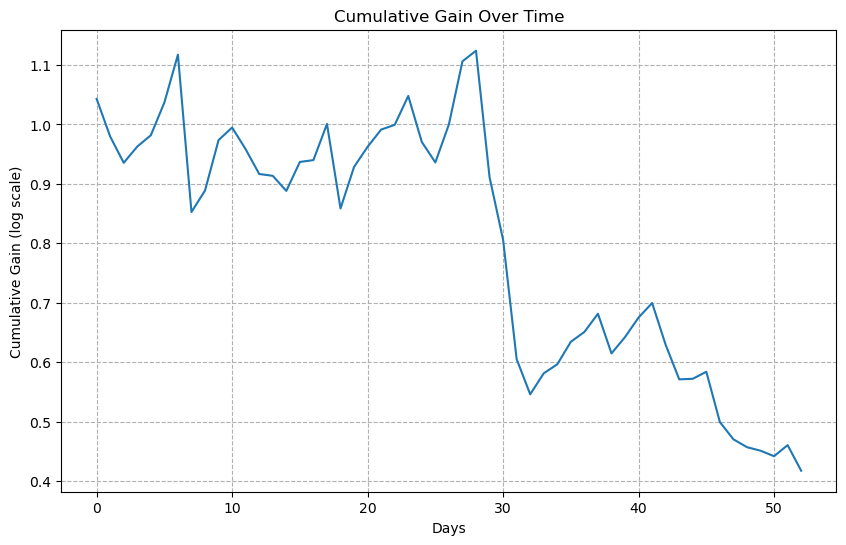

Cumulative Gain after 53 days: -58.26%, Average daily gain: -1.64%, Annualized profit on capital: -98.38% 
Maximum Drawdown: -62.87%, Max Drawdown (last 120 days): -62.87%
Maximum Drawdown Duration: 24 days, Max Drawdown Duration (last 120 days): 24 days
Sharpe Ratio: -0.1570446640253067, mean profit: -2.56%, std: 16.31%
Winning days: 30 / 53, Win rate: 56.60%


In [257]:
# profits_flat = rearrange(profits_backup, 'd t s tr -> d (t s tr)')[-160:]
# half_gains = profits_flat @ (kelly_flat * 0.5) + 1.0
# cumulative_gains = half_gains.cumprod(dim=0)
cumulative_gains = quarter_gains.cumprod(dim=0)

import matplotlib.pyplot as plt
# Plot using a log scale for y-axis
plt.figure(figsize=(10, 6))
plt.plot(cumulative_gains.cpu().numpy())
# plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Cumulative Gain (log scale)')
plt.title('Cumulative Gain Over Time')
plt.grid(True, which="both", ls="--")
plt.show()

# Calculate max drawdown
running_max = torch.cummax(cumulative_gains, dim=0).values
drawdowns = (cumulative_gains - running_max) / running_max
print(f"Cumulative Gain after {cumulative_gains.size(0)} days: {(cumulative_gains[-1].item()-1.0)*100:.2f}%, Average daily gain: {(cumulative_gains[-1].item() ** (1.0 / cumulative_gains.size(0))-1.0) * 100:.2f}%, Annualized profit on capital: {(cumulative_gains[-1].item() ** (250.0 / cumulative_gains.size(0))-1.0) * 100:.2f}% ")
if len(cumulative_gains) > 120:
    print(f"Cumulative Gain last 120 days: {cumulative_gains[-1].item() / cumulative_gains[-120].item()}, Average daily gain (last 120 days): {(cumulative_gains[-1].item() / cumulative_gains[-120].item()) ** (1.0 / 120)}")
    max_drawdown_120 = drawdowns[-120:].min().item()
else:
    max_drawdown_120 = drawdowns.min().item()
max_drawdown = drawdowns.min().item()
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%, Max Drawdown (last 120 days): {max_drawdown_120 * 100:.2f}%")
max_drawdown_duration = 0
current_duration = 0
for i in range(1, len(drawdowns)):
    if drawdowns[i] < 0:
        current_duration += 1
        max_drawdown_duration = max(max_drawdown_duration, current_duration)
    else:
        current_duration = 0

max_drawdown_duration_120 = 0
current_duration = 0
if len(drawdowns) > 120:
    for i in range(len(drawdowns) - 120, len(drawdowns)):
        if drawdowns[i] < 0:
            current_duration += 1
            max_drawdown_duration_120 = max(max_drawdown_duration_120, current_duration)
        else:
            current_duration = 0
else:
    max_drawdown_duration_120 = max_drawdown_duration

print(f"Maximum Drawdown Duration: {max_drawdown_duration} days, Max Drawdown Duration (last 120 days): {max_drawdown_duration_120} days")
sharpe_ratio = ((half_gains - 1.0).mean()) / (half_gains - 1.0).std().item()
print(f"Sharpe Ratio: {sharpe_ratio}, mean profit: {(half_gains.mean().item()-1.0)*100:.2f}%, std: {half_gains.std().item()*100:.2f}%")
print(f"Winning days: {(half_gains > 1.0).sum().item()} / {half_gains.size(0)}, Win rate: {(half_gains > 1.0).sum().item() / half_gains.size(0) * 100:.2f}%")
if len(half_gains) > 120:
    print(f"Winning days (last 120 days): {(half_gains[-120:] > 1.0).sum().item()} / 120, Win rate (last 120 days): {(half_gains[-120:] > 1.0).sum().item() / 120 * 100:.2f}%")


- TOPK 2
- Cumulative Gain after 53 days: 45.52%, Average daily gain: 0.71%, Annualized profit on capital: 486.78% 
- Maximum Drawdown: -7.90%, Max Drawdown (last 120 days): -7.90%
- Maximum Drawdown Duration: 14 days, Max Drawdown Duration (last 120 days): 14 days
- Sharpe Ratio: 0.35375717282295227, mean profit: 1.46%, std: 4.13%
- Winning days: 40 / 53, Win rate: 75.47%

In [311]:
half_gains[-20:]-1.0

tensor([ 0.0004,  0.0056,  0.0069,  0.0069, -0.0068,  0.0142,  0.0134,  0.0134,
         0.0200,  0.0477,  0.0083, -0.0099, -0.0087,  0.0063,  0.0179,  0.0266,
         0.0048,  0.0120, -0.0058,  0.0032], device='cuda:0')

In [30]:
kelly = rearrange(kelly_flat, '(t s tr) -> t s tr', t=len(unique_times), s=len(unique_symbols), tr=len(unique_trades))

kelly.nonzero()



tensor([[ 3,  3,  0],
        [37,  3,  0],
        [46,  4,  2],
        [54,  1,  2],
        [58,  3,  0]], device='cuda:0')

In [34]:
profits[128, 3, 3, 0], profits[128, 37, 3, 0], profits[128, 46, 4, 2], profits[128, 54, 1, 2], profits[128, 58, 3, 0]

unique_dates[128], unique_times[58], unique_symbols[3], unique_trades[0]


(tensor(20250404, device='cuda:0', dtype=torch.int32),
 tensor(1425, device='cuda:0', dtype=torch.int32),
 tensor(3, device='cuda:0', dtype=torch.int32),
 tensor(0, device='cuda:0', dtype=torch.int32))

In [35]:
df_processed[(df_processed['DateInt'] == 20250404) & (df_processed['TimeInt'] == 1425) & (df_processed['SymbolID'] == 3) & (df_processed['TradeID'] == 0)]

,DateInt,TimeInt,SymbolID,TradeID,ProfitPercent
250438,20250404,1425,3,0,102.9


In [36]:
id_to_symbol[int(unique_symbols[3].item())], id_to_trade_type[int(unique_trades[0].item())]

('QQQ', 'Butterfly')

In [37]:
# Get rows where Symbol is 'XSP' and Name is 'Sonar'Any
df_data[(df_data['Symbol'] == 'QQQ') & (df_data['Name'] == 'Butterfly') & (df_data['DateTime'].dt.date == pd.Timestamp('2025-04-04').date())]

,Symbol,Name,Premium,Risk,Strike1,Direction1,Type1,Bid1,Ask1,Strike2,...,DateTime,Price,Raw,Trade,Premium_orig,Premium_calc,Risk_orig,Profit,Commission,NetProfit
248567,QQQ,Butterfly,0.97,97.0,444.0,LONG,CALL,1.81,1.88,439.0,...,2025-04-04 09:35:00,437.54,-94.0,BUY +1 Butterfly QQQ 100 04 Apr 25 444/439/434...,0.94,0.97,94.0,-97.0,5.1,-102.1
248610,QQQ,Butterfly,0.95,95.0,444.0,LONG,CALL,1.34,1.36,439.0,...,2025-04-04 09:40:00,435.56,-94.0,BUY +1 Butterfly QQQ 100 04 Apr 25 444/439/434...,0.94,0.95,94.0,-95.0,5.1,-100.1
248640,QQQ,Butterfly,0.96,96.0,444.0,LONG,CALL,1.40,1.41,439.0,...,2025-04-04 09:45:00,435.94,-97.0,BUY +1 Butterfly QQQ 100 04 Apr 25 444/439/434...,0.97,0.96,97.0,-96.0,5.1,-101.1
248683,QQQ,Butterfly,0.95,95.0,444.0,LONG,CALL,1.79,1.81,439.0,...,2025-04-04 09:50:00,438.03,-95.0,BUY +1 Butterfly QQQ 100 04 Apr 25 444/439/434...,0.95,0.95,95.0,-95.0,5.1,-100.1
248714,QQQ,Butterfly,0.92,92.0,444.0,LONG,CALL,1.45,1.48,439.0,...,2025-04-04 09:55:00,436.48,-89.0,BUY +1 Butterfly QQQ 100 04 Apr 25 444/439/434...,0.89,0.92,89.0,-92.0,5.1,-97.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250500,QQQ,Butterfly,0.91,91.0,424.0,LONG,CALL,2.80,2.83,421.0,...,2025-04-04 14:35:00,425.14,18.0,BUY +1 Butterfly QQQ 100 04 Apr 25 424/421/418...,0.91,0.91,91.0,18.0,5.1,12.9
250528,QQQ,Butterfly,0.47,47.0,424.0,LONG,CALL,2.67,2.69,421.0,...,2025-04-04 14:40:00,424.85,62.0,BUY +1 Butterfly QQQ 100 04 Apr 25 424/421/418...,0.47,0.47,47.0,62.0,5.1,56.9
250564,QQQ,Butterfly,0.50,50.0,424.0,LONG,CALL,2.24,2.27,421.0,...,2025-04-04 14:45:00,424.03,58.0,BUY +1 Butterfly QQQ 100 04 Apr 25 424/421/418...,0.51,0.50,51.0,59.0,5.1,53.9
250587,QQQ,Butterfly,0.37,37.0,424.0,LONG,CALL,3.17,3.25,421.0,...,2025-04-04 14:50:00,425.86,73.0,BUY +1 Butterfly QQQ 100 04 Apr 25 424/421/418...,0.36,0.37,36.0,72.0,5.1,66.9
